In [1]:
import scipy.io
import numpy as np

# Carregar dades des del fitxer .mat 
mat = scipy.io.loadmat(r"C:\Users\joana\Documents\Projectes personals\TR\matlab\matlab\emnist-letters.mat")

# Accedir a les dades
X_letters_train = mat['dataset']['train'][0,0]['images'][0,0]
y_letters_train = mat['dataset']['train'][0,0]['labels'][0,0]
X_letters_test = mat['dataset']['test'][0,0]['images'][0,0]
y_letters_test = mat['dataset']['test'][0,0]['labels'][0,0]

# Reformatar
X_letters_train = X_letters_train.reshape((-1, 28, 28), order='F').astype(np.uint8)
X_letters_test = X_letters_test.reshape((-1, 28, 28), order='F').astype(np.uint8)
y_letters_train = y_letters_train.flatten() - 1  # Canviar de 1-26 a 0-25
y_letters_test = y_letters_test.flatten() - 1

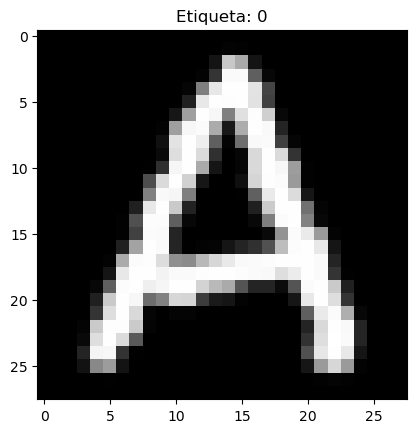

In [2]:
import matplotlib.pyplot as plt

plt.imshow(X_letters_train[32], cmap='gray')
plt.title(f"Etiqueta: {y_letters_train[32]}")
plt.show()

In [3]:
mat_digits = scipy.io.loadmat(r"C:\Users\joana\Documents\Projectes personals\TR\matlab\matlab\emnist-digits.mat")

# Dades d'entrenament
X_digits_train = mat_digits['dataset']['train'][0,0]['images'][0,0]
y_digits_train = mat_digits['dataset']['train'][0,0]['labels'][0,0]

# Dades de test
X_digits_test = mat_digits['dataset']['test'][0,0]['images'][0,0]
y_digits_test = mat_digits['dataset']['test'][0,0]['labels'][0,0]

In [4]:
# Format de les imatges (vector --> matriu 28x28)
X_digits_train = X_digits_train.reshape(-1, 28, 28, order='F').astype(np.uint8)
X_digits_test = X_digits_test.reshape(-1, 28, 28, order='F').astype(np.uint8)

# Ajusta etiquetes: els dígits van del 0 al 9, no cal restar 1
y_digits_train = y_digits_train.flatten()
y_digits_test = y_digits_test.flatten()

# Reassignar etiquetes dels dígits perquè no se solapin amb les lletres
y_digits_train += 26
y_digits_test += 26

In [5]:
# Unim els conjunts d'entrenament
X_train_total = np.concatenate([X_letters_train, X_digits_train], axis=0)
y_train_total = np.concatenate([y_letters_train, y_digits_train], axis=0)

# I els conjunts de test
X_test_total = np.concatenate([X_letters_test, X_digits_test], axis=0)
y_test_total = np.concatenate([y_letters_test, y_digits_test], axis=0)

# Normalització: valors entre 0 i 1
X_train_total = X_train_total / 255.0
X_test_total = X_test_total / 255.0

# Afegim canal (blanc i negre = 1 canal)
X_train_total = X_train_total.reshape(-1, 28, 28, 1)
X_test_total = X_test_total.reshape(-1, 28, 28, 1)

In [7]:
# Aplanem les imatges: de (28, 28, 1) → (784,)
X_train_flat = X_train_total.reshape(len(X_train_total), -1)
X_test_flat = X_test_total.reshape(len(X_test_total), -1)

In [8]:
from sklearn.neural_network import MLPClassifier

# Creo el model
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),  # 3 capes ocultes amb més neurones
    activation='relu',                  # Funció d'activació
    solver='adam',                      # Optimitzador Adam
    alpha=1e-4,                         # Regularització L2 (evita overfitting)
    batch_size=128,                     # Nombre d'exemples per batch
    learning_rate='adaptive',           # Adaptar LR segons rendiment
    max_iter=30,                        # Nombre d'epochs
    verbose=True,
    random_state=42
)

# Entrenament
mlp.fit(X_train_flat, y_train_total)

Iteration 1, loss = 0.47726808


c:\Users\joana\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(batch_size=128, hidden_layer_sizes=(512, 256, 128),
              learning_rate='adaptive', max_iter=30, random_state=42,
              verbose=True)

In [ ]:
from joblib import dump, load

# Guardar el model entrenat
dump(mlp, r"C:\Users\joana\Documents\Projectes personals\TR\projecte\model2_mlp.joblib")

# Carregar-lo més endavant
mlp_loaded = load( r"C:\Users\joana\Documents\Projectes personals\TR\projecte\model2_mlp.joblib")

# Provar que funciona
y_pred = mlp_loaded.predict(X_test_flat)
print("Accuracy després de carregar:", (y_pred == y_test_total).mean())

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Prediccions
y_pred = mlp.predict(X_test_flat)

# Precisió
print("Precisió del model:", accuracy_score(y_test_total, y_pred))

# Informe detallat
print(classification_report(y_test_total, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Crear la matriu de confusió
cm = confusion_matrix(y_test_total, y_pred)

# Etiquetes: A–Z + 0–9
labels = list(string.ascii_uppercase) + [str(i) for i in range(10)]

# Mostrar la matriu
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(16, 16))
disp.plot(ax=ax, cmap='Purples', xticks_rotation=90, colorbar=True)
plt.title("Matriu de confusió: lletres i dígits")
plt.show()

In [ ]:
# Calculem per a cada classe:
# - el nombre total de mostres (suma de files)
# - el nombre d'encerts (diagonal)
# - el percentatge d'encerts
total_per_class = cm.sum(axis=1)
correct_per_class = np.diag(cm)
accuracy_per_class = correct_per_class / total_per_class

# Ordenem les classes de menys a més precises
worst_indices = np.argsort(accuracy_per_class)[:10]  # Les 10 pitjors

print("Classes més problemàtiques:")
for idx in worst_indices:
    label = labels[idx]
    acc = accuracy_per_class[idx] * 100
    print(f"- Classe '{label}': {acc:.2f}% d'encerts ({correct_per_class[idx]} de {total_per_class[idx]})")